<a href="https://colab.research.google.com/github/ThourayaBchir/transformers/blob/main/T2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimal GPT Implementation and Training on TinyShakespeare with PyTorch

Minimal GPT Training from Scratch on TinyShakespeare (Character-Level)
This script implements a compact, fully-trainable GPT-like language model using PyTorch. It demonstrates:

- A minimal transformer decoder architecture (GPT) built from scratch using self-attention and feed-forward layers.

- Character-level language modeling on the Tiny Shakespeare dataset.

- Training with mixed-precision (autocast & GradScaler), gradient clipping, and learning rate scheduling (OneCycleLR).

- Optional end-to-end kernel fusion via torch.compile for acceleration.

- Live tracking of training loss and timing metrics.

The model learns to predict the next character in a sequence and can be adapted for other sequence modeling tasks with minimal changes.

<ipython-input-2-4ebdddcfb184>:165: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
<ipython-input-2-4ebdddcfb184>:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 0 Batch 0/69709 Loss 4.3127


<ipython-input-2-4ebdddcfb184>:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 0 Batch 200/69709 Loss 3.7709
Epoch 0 Batch 400/69709 Loss 3.2485
Epoch 0 Batch 600/69709 Loss 3.0604
Epoch 0 Batch 800/69709 Loss 2.9554
Epoch 0 Batch 1000/69709 Loss 2.9497
Epoch 0 Batch 1200/69709 Loss 2.8255
Epoch 0 Batch 1400/69709 Loss 2.7445
Epoch 0 Batch 1600/69709 Loss 2.7628
Epoch 0 Batch 1800/69709 Loss 2.5942
Epoch 0 Batch 2000/69709 Loss 2.5836
Epoch 0 Batch 2200/69709 Loss 2.5306
Epoch 0 Batch 2400/69709 Loss 2.5777
Epoch 0 Batch 2600/69709 Loss 2.5408
Epoch 0 Batch 2800/69709 Loss 2.5268
Epoch 0 Batch 3000/69709 Loss 2.4763
Epoch 0 Batch 3200/69709 Loss 2.5542
Epoch 0 Batch 3400/69709 Loss 2.5447
Epoch 0 Batch 3600/69709 Loss 2.4783
Epoch 0 Batch 3800/69709 Loss 2.5069
Epoch 0 Batch 4000/69709 Loss 2.4785
Epoch 0 Batch 4200/69709 Loss 2.4929
Epoch 0 Batch 4400/69709 Loss 2.5074
Epoch 0 Batch 4600/69709 Loss 2.4894
Epoch 0 Batch 4800/69709 Loss 2.4265
Epoch 0 Batch 5000/69709 Loss 2.4908
Epoch 0 Batch 5200/69709 Loss 2.4760
Epoch 0 Batch 5400/69709 Loss 2.4378
Epoch

<ipython-input-2-4ebdddcfb184>:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 Batch 200/69709 Loss 1.7243
Epoch 1 Batch 400/69709 Loss 1.5952
Epoch 1 Batch 600/69709 Loss 1.4656
Epoch 1 Batch 800/69709 Loss 1.5068
Epoch 1 Batch 1000/69709 Loss 1.5289
Epoch 1 Batch 1200/69709 Loss 1.6021
Epoch 1 Batch 1400/69709 Loss 1.5475
Epoch 1 Batch 1600/69709 Loss 1.4990
Epoch 1 Batch 1800/69709 Loss 1.5427
Epoch 1 Batch 2000/69709 Loss 1.5547
Epoch 1 Batch 2200/69709 Loss 1.4506
Epoch 1 Batch 2400/69709 Loss 1.5170
Epoch 1 Batch 2600/69709 Loss 1.6962
Epoch 1 Batch 2800/69709 Loss 1.4382
Epoch 1 Batch 3000/69709 Loss 1.5846
Epoch 1 Batch 3200/69709 Loss 1.5692
Epoch 1 Batch 3400/69709 Loss 1.6693
Epoch 1 Batch 3600/69709 Loss 1.5911
Epoch 1 Batch 3800/69709 Loss 1.5800
Epoch 1 Batch 4000/69709 Loss 1.5633
Epoch 1 Batch 4200/69709 Loss 1.5980
Epoch 1 Batch 4400/69709 Loss 1.5599
Epoch 1 Batch 4600/69709 Loss 1.5242
Epoch 1 Batch 4800/69709 Loss 1.5895
Epoch 1 Batch 5000/69709 Loss 1.5310
Epoch 1 Batch 5200/69709 Loss 1.5945
Epoch 1 Batch 5400/69709 Loss 1.6055
Epoch

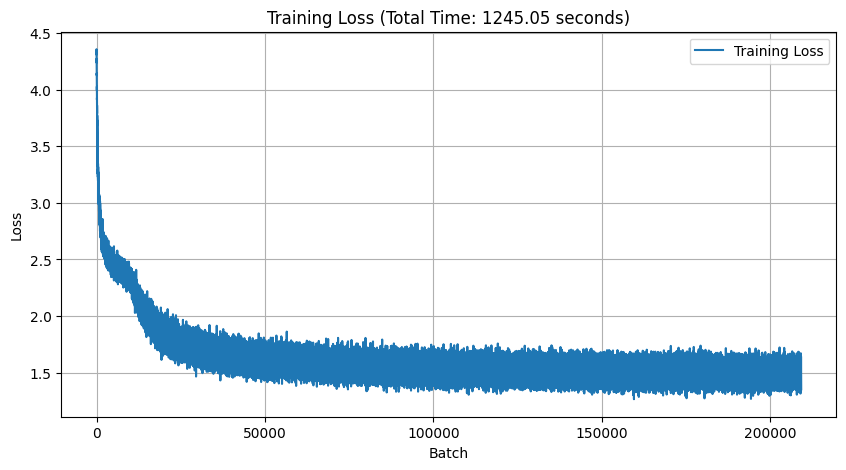


Training Statistics:
Total training time: 1245.05 seconds
Average epoch time: 415.02 seconds
Average batch time: 0.0057 seconds
Final loss: 1.3459


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import requests


from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader



# ──────────────────────────────────────────────────────────────────────────────
# 1) Define GPTConfig, CausalSelfAttention, FeedForward, DecoderLayer, GPT
# (as per previous minimal implementation)
# ──────────────────────────────────────────────────────────────────────────────

class GPTConfig:
    def __init__(self, vocab_size, seq_len, d_model=128, heads=4, num_layers=2, d_ff=512, dropout=0.1):
        self.vocab_size = vocab_size
        self.seq_len    = seq_len
        self.d_model    = d_model
        self.heads      = heads
        self.num_layers = num_layers
        self.d_k        = d_model // heads
        self.d_ff       = d_ff
        self.dropout    = dropout

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_heads = config.heads
        self.d_k       = config.d_k
        self.scale     = self.d_k ** -0.5
        self.qkv_proj  = nn.Linear(config.d_model, 3 * config.d_model)
        self.out_proj  = nn.Linear(config.d_model, config.d_model)
        mask = torch.tril(torch.ones(config.seq_len, config.seq_len))
        self.register_buffer("mask", mask.view(1,1,config.seq_len,config.seq_len))
        self.dropout   = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.qkv_proj(x).view(B, T, 3, self.num_heads, self.d_k).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale
        attn_scores = attn_scores.masked_fill(self.mask[:,:,:T,:T]==0, float('-inf'))
        attn_probs  = F.softmax(attn_scores, dim=-1)
        attn_probs  = self.dropout(attn_probs)
        attn_output = attn_probs @ v
        attn_output = attn_output.transpose(1,2).reshape(B, T, C)
        return self.out_proj(attn_output)



class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1     = nn.Linear(config.d_model, config.d_ff)
        self.fc2     = nn.Linear(config.d_ff,  config.d_model)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.fc2(self.dropout(F.gelu(self.fc1(x))))

class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1  = nn.LayerNorm(config.d_model)
        self.attn = CausalSelfAttention(config)
        self.ln2  = nn.LayerNorm(config.d_model)
        self.ff   = FeedForward(config)
        self.drop = nn.Dropout(config.dropout)
    def forward(self, x):
        x = x + self.drop(self.attn(self.ln1(x)))
        x = x + self.drop(self.ff(self.ln2(x)))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.seq_len, config.d_model))
        self.drop    = nn.Dropout(config.dropout)
        self.layers  = nn.ModuleList([DecoderLayer(config) for _ in range(config.num_layers)])
        self.ln_f    = nn.LayerNorm(config.d_model)
        self.head    = nn.Linear(config.d_model, config.vocab_size, bias=False)
    def forward(self, x):
        B, T = x.size()
        x = self.tok_emb(x) + self.pos_emb[:, :T, :]
        x = self.drop(x)
        for layer in self.layers:
            x = layer(x)
        x = self.ln_f(x)
        return self.head(x)

# ──────────────────────────────────────────────────────────────────────────────
# 2) Prepare Tiny Shakespeare dataset (char-level)
# ──────────────────────────────────────────────────────────────────────────────

# Download dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(url).text

# Build char-level vocab
chars = sorted(set(text))
vocab = {ch:i for i,ch in enumerate(chars)}
ivocab = {i:ch for ch,i in vocab.items()}

# Encode entire text as tensor
data = torch.tensor([vocab[ch] for ch in text], dtype=torch.long)

# Dataset and DataLoader
class CharDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    def __len__(self):
        return len(self.data) - self.seq_len
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+1:idx+1+self.seq_len]
        return x, y

seq_len = 64
batch_size = 16
dataset = CharDataset(data, seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ──────────────────────────────────────────────────────────────────────────────
# 3) Instantiate and train the GPT model
# ──────────────────────────────────────────────────────────────────────────────

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = GPTConfig(vocab_size=len(vocab), seq_len=seq_len,
                   d_model=128, heads=4, num_layers=2, d_ff=512, dropout=0.1)


model = GPT(config).to(device)
model = torch.compile(model, backend="inductor")    # fuse kernels end-to-end

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scaler    = GradScaler()
sched     = OneCycleLR(
    optimizer,
    max_lr=3e-4,
    total_steps=3 * len(dataloader),  # epochs * steps_per_epoch
    pct_start=0.1,
    anneal_strategy="cos",
)


import time
import matplotlib.pyplot as plt

# Add these at the beginning of your training section
train_losses = []
batch_times = []
epoch_times = []
start_time = time.time()

model.train()
for epoch in range(3):
    epoch_start_time = time.time()
    total_loss = 0.0

    for batch_idx, (x, y) in enumerate(dataloader):
        batch_start_time = time.time()

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        with autocast():
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, config.vocab_size), y.view(-1))

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        sched.step()

        total_loss += loss.item()
        train_losses.append(loss.item())  # Store each batch loss
        batch_time = time.time() - batch_start_time
        batch_times.append(batch_time)

        if batch_idx % 200 == 0:
            print(f"Epoch {epoch} Batch {batch_idx}/{len(dataloader)} Loss {loss.item():.4f}")

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    avg = total_loss / len(dataloader)
    print(f"Epoch {epoch} Completed. Avg Loss: {avg:.4f}")

total_time = time.time() - start_time

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title(f'Training Loss (Total Time: {total_time:.2f} seconds)')
plt.legend()
plt.grid(True)
plt.show()

# Print timing information
print("\nTraining Statistics:")
print(f"Total training time: {total_time:.2f} seconds")
print(f"Average epoch time: {sum(epoch_times)/len(epoch_times):.2f} seconds")
print(f"Average batch time: {sum(batch_times)/len(batch_times):.4f} seconds")
print(f"Final loss: {train_losses[-1]:.4f}")

In [ ]:
model.eval()

OptimizedModule(
  (_orig_mod): GPT(
    (tok_emb): Embedding(65, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ff): FeedForward(
          (fc1): Linear(in_features=128, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (head): Linear(in_features=128, out_features=65, bias=False)
  )
)

In [ ]:
# prompt = "Time is"  # Example prompt
# input_ids = torch.tensor([[vocab[ch] for ch in prompt]], dtype=torch.long).to(device)

In [ ]:
def generate_text(model, prompt, max_new_tokens=100, temperature=1.0):
    # Encode prompt
    input_ids = torch.tensor([[vocab[ch] for ch in prompt]], dtype=torch.long).to(device)

    for _ in range(max_new_tokens):
        # Forward pass (crop if input exceeds seq_len)
        logits = model(input_ids[:, -seq_len:])

        # Get last predicted token
        logits = logits[:, -1, :] / temperature  # Apply temperature
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append to input
        input_ids = torch.cat([input_ids, next_token], dim=-1)

    # Decode tokens to text
    generated_text = ''.join([ivocab[i.item()] for i in input_ids[0]])
    return generated_text

In [ ]:
generated_text = generate_text(model, "ROMEO: ", max_new_tokens=200, temperature=1)
print(generated_text)

ROMEO: here! thou shalt stand my life?
We best me noble fellow.

CORIOLANUS:
What's I rememberless.

Feirst Lady:
O my charged should begunds and dry word!

MENENIUS:
Why, my lord?

CLAUDIO:
This same sends,
